# Homogeneous Medium Initial Value Problem

*This example notebook follows the [Homogeneous Propagation Medium Example](http://www.k-wave.org/documentation/example_ivp_homogeneous_medium.php) of [k-Wave](http://www.k-wave.org/).*

## Setting the domain

Similarly to k-Wave, jWave requires the user to specify a computational domain where the simulation takes place. This is done using the `Domain` dataclass which is lifted from [`jaxdf`](https://github.com/ucl-bug/jaxdf).

The inputs for the constructor are the size of the domain in grid points in each spatial direction, and the corresponding discretization step.

In [1]:
from jwave.geometry import Domain

N, dx = (128, 128), (0.1e-3, 0.1e-3)
domain = Domain(N, dx)

## Setting up the simulation

In this example, the speed of sound has a constant value of $1500m/s$.

In [2]:
from jax import numpy as jnp
from jwave.geometry import Medium

sound_speed = jnp.ones(N)*1500
medium = Medium(domain=domain, sound_speed=sound_speed)

print("Medium parameters:")
Medium.__annotations__

Medium parameters:


{'domain': jaxdf.geometry.Domain,
 'sound_speed': jax._src.numpy.lax_numpy.ndarray,
 'density': jax._src.numpy.lax_numpy.ndarray,
 'attenuation': jax._src.numpy.lax_numpy.ndarray,
 'pml_size': float}

We also need to define a `TimeAxis` object, which defines the timestepping scheme of the numerical simulation. To ensure a stable simulation, this object can be constructed from the `medium` for a given [CFL number](https://it.wikipedia.org/wiki/Condizione_di_Courant-Friedrichs-Lewy).

In [3]:
from jwave.geometry import TimeAxis

time_axis = TimeAxis.from_medium(medium, cfl=0.3)

print("TimeAxis parameters:")
TimeAxis.__annotations__

TimeAxis parameters:


{'dt': float, 't_end': float}

The last two objects that need to be defined are a ring of sensors

In [4]:
from jwave.geometry import _points_on_circle, Sensors

num_sensors = 32
x, y = _points_on_circle(num_sensors,40,(64,64))
sensors_positions = (jnp.array(x), jnp.array(y))
sensors = Sensors(positions=sensors_positions)

print("Sensors parameters:")
Sensors.__annotations__

Sensors parameters:


{'positions': typing.Tuple[jax._src.numpy.lax_numpy.ndarray]}

and an initial pressure distribution

In [5]:
from jwave.geometry import _circ_mask

mask1 = _circ_mask(N, 8, (50,50))
mask2 = _circ_mask(N, 5, (80,60))
mask3 = _circ_mask(N, 10, (64,64))
mask4 = _circ_mask(N, 30, (64,64))
p0 = 5.*mask1 + 3.*mask2 + 4.*mask3 + 0.5*mask4

In [6]:
def show_field(x, title="", vmax=None):
    plt.figure(figsize=(8,6))
    maxval = vmax or jnp.amax(jnp.abs(x))
    plt.imshow(x, cmap="RdBu_r", vmin=-maxval, vmax=maxval, interpolation='nearest', aspect='auto')
    plt.colorbar()
    plt.title(title)
    plt.axis("off")
    return None

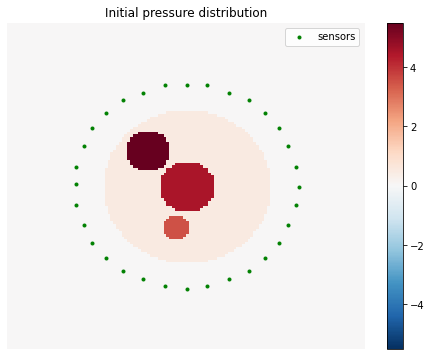

In [7]:
# Show simulation setup
from matplotlib import pyplot as plt

show_field(p0, "Initial pressure distribution")
plt.scatter(sensors_positions[1],sensors_positions[0], c='g', marker='.', label="sensors")
plt.legend()
plt.show()

## Running the simulation

To run the simulation, we first need to construct a solver using the objects we've just created.

In [8]:
from jwave.acoustics import ongrid_wave_propagation

params, solver = ongrid_wave_propagation(
    medium=medium,
    time_array=time_axis,
    output_t_axis = time_axis,
    sensors=sensors,
    backprop=True,
    p0 = p0
)

A solver is a function that takes a dictionary of parameters `params` and returns the pressure signal at the sensor positions, for each time instant.

The `params` field contains all the numerical values required for running the simulation. For example, the following is the initial acoustic density field used in the simulation (remember that this field is smoothed, as described in [Sec. 2.8 of the k-Wave manual](http://www.k-wave.org/manual/k-wave_user_manual_1.1.pdf))

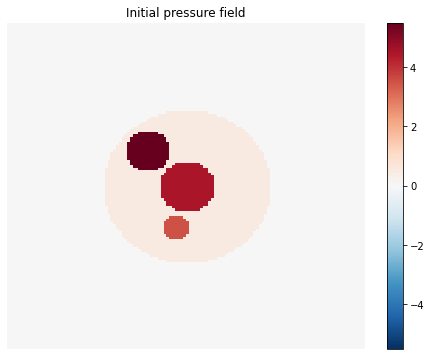

In [9]:
show_field(params["initial_fields"]["p"], "Initial pressure field")

The `solver` function can be transfromed with JAX program transformations, such as `jit` for fast execution via just-in-time compilation, and gradients can be evaluated with respect to any subsets of `params` values.

In [10]:
from jax import jit

solver = jit(solver)
sensors_data = solver(params)

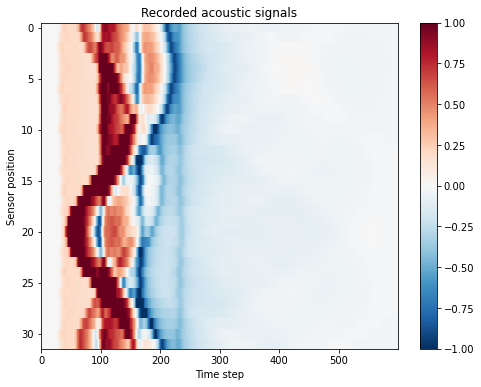

In [11]:
show_field(sensors_data.T, "Recorded acoustic signals", vmax=1)
plt.xlabel("Time step")
plt.ylabel("Sensor position")
plt.axis("on")
plt.show()

In [12]:
%timeit solver(params).block_until_ready()

44.6 ms ± 121 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


## Automatic differentiation

We can take the gradient with respect to any scalar loss, as shown in the following example.
Note that taking gradients with autodiff can be also used to generate imaging algorithms:

In [13]:
from jwave.signal_processing import smooth
from jax import random

noise = random.normal(random.PRNGKey(42), sensors_data.shape)
for i in range(noise.shape[1]):
    noise = noise.at[:,i].set(smooth(noise[:,i]))

noisy_data = sensors_data + 0.2*noise

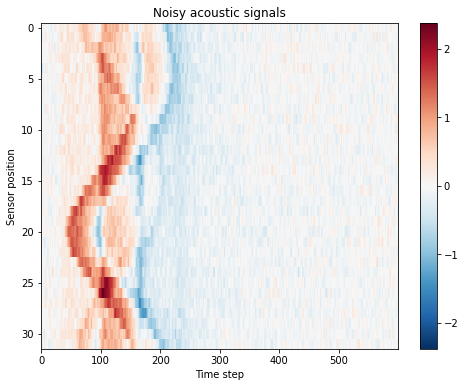

In [14]:
show_field(noisy_data.T, "Noisy acoustic signals")
plt.xlabel("Time step")
plt.ylabel("Sensor position")
plt.axis("on")
plt.show()

In [15]:
from jax import grad

@jit # Compile the whole algorithm
def lazy_time_reversal(p):
    
    # Mask out elements outside the sensors ring
    mask = _circ_mask(N, 39, (64,64))

    def mse_loss(p0):
        local_params = params.copy()
        local_params["initial_fields"]["p"] = p0*mask
        p_pred = solver(local_params)
        return 0.5*jnp.sum(jnp.abs(p_pred - p)**2)
    
    p0 = jnp.zeros_like(params["initial_fields"]["p"])
    p_grad = grad(mse_loss)(p0)
    
    return -p_grad


recon_image = lazy_time_reversal(noisy_data)

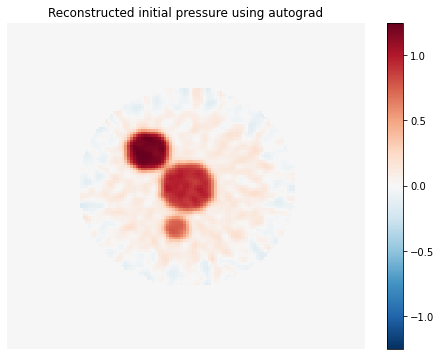

In [16]:
show_field(recon_image, 'Reconstructed initial pressure using autograd')

In [17]:
%timeit lazy_time_reversal(noisy_data).block_until_ready()

86.6 ms ± 167 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)
